# MSCA 31008 - Data Mining Assignment 2 (Group 4)
<b>Prinu Mathew, Qingwei Zhang, Jake Brewer</b><br>
<b>Winter 2023</b>

### Import Libraries  

In [30]:
import sys, os, json, subprocess

## for data
import pandas as pd
import numpy as np
import datetime

## for machine learning
from scipy import stats
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings('ignore')

In [31]:
## for machine learning
try:
    from kneed import KneeLocator
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.cluster import KMeans
    from sklearn.mixture import GaussianMixture
    from sklearn.metrics import silhouette_score
    import sklearn.datasets
        
    print("~~~ Already installed required packages for machine learning ~~~~")
except Exception as e:
    print(e)
    
    print("~~~ Installing required packages for machine learning ~~~~")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "kneed"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "scikit-learn"])
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.cluster import KMeans
    from sklearn.mixture import GaussianMixture
    from sklearn.metrics import silhouette_score
    import sklearn.datasets

~~~ Already installed required packages for machine learning ~~~~


In [32]:
## for interactive visualization
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    print("~~~ Already installed required packages for interactive visualizations ~~~~")
except Exception as e:
    print(e)
    
    print("~~~ Installing required packages for interactive visualizations ~~~~")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "matplotlib"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "seaborn"])
    import matplotlib.pyplot as plt
    import seaborn as sns
    
%matplotlib inline

~~~ Already installed required packages for interactive visualizations ~~~~


## 1. Read dataset
Include all variables except for MEDV (Median value of owner-occupied homes in $1000's). Since MEDV typically would be the target variable that we want to predict we should exclude it so that the clusters only consist of predictor (independent) variables.

In [33]:
# reading the CSV file
input_df = pd.read_csv('BostonHousing.csv', quotechar='"', delimiter = ',')
input_df.head(10)
X = input_df.drop(columns=['MEDV'])
input_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## 2. Scale the Data Using MinMaxScaler

In [34]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33


In [67]:
# split data into training and testing and scale using Min-Max scaling
X_train, X_test = train_test_split(X, test_size=.3, random_state=50)

scaler  = MinMaxScaler(feature_range=(0, 1))
model=scaler.fit(X_train) # fit just to train data
X_train = model.transform(X_train) # transform train using fitted train
X_test = model.transform(X_test) # transform test using fitted train

In [68]:
X_train

array([[2.33528471e-03, 2.20000000e-01, 1.97947214e-01, ...,
        6.91489362e-01, 9.49708344e-01, 5.27659574e-02],
       [2.92795719e-04, 0.00000000e+00, 6.30498534e-02, ...,
        6.48936170e-01, 9.94242962e-01, 3.43262411e-02],
       [6.80252688e-03, 2.00000000e-01, 1.28665689e-01, ...,
        4.25531915e-02, 9.81739792e-01, 9.61702128e-02],
       ...,
       [9.79031331e-02, 0.00000000e+00, 6.46627566e-01, ...,
        8.08510638e-01, 9.87522191e-01, 4.36595745e-01],
       [6.53894329e-02, 0.00000000e+00, 6.46627566e-01, ...,
        8.08510638e-01, 1.00000000e+00, 2.55602837e-01],
       [7.18220593e-04, 0.00000000e+00, 1.31598240e-01, ...,
        4.25531915e-01, 9.90692366e-01, 2.37730496e-01]])

## 3. Generate K-means Solutions with 2-10 Clusters
<b>Distortion</b>: It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used.<br>
<b>Inertia</b>: It is the sum of squared distances of samples to their closest cluster center.

In [37]:
min_clusters = 2
max_clusters = 11
kmean_random_state = 50 #Determines random number generation for centroid initialization
kmean_n_init= 100       #The number of initializations to perform. The best results are kept.

In [83]:
# run kmeans with various number of clusters
distortions = []
wcss = []
clus_size = []
centroids = []
distortions_mapping = {}
wcss_mapping = {}

kmeans_kwargs = {
    "init": "random",
    "n_init": kmean_n_init,
    "max_iter": 300,
    "random_state": kmean_random_state,
}
K = range(min_clusters, max_clusters)

# inertia or WCSS (Within Cluster Sum of Squares) measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, 
# squaring this distance, and summing these squares across one cluster. A good model is one with low inertia AND a low number of clusters ( K )
for i in K:
    kmeans = KMeans(n_clusters=i, **kmeans_kwargs)
    kmeans.fit(X_train)
    kmeans.transform(X_train)

    # calcuate distortion
    distortion = sum(np.min(cdist(X_train, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_train.shape[0]
    distortions.append(distortion)
    distortions_mapping[i] = distortion

    # get WCSS (Within Cluster Sum of Squares)
    wcss.append(kmeans.inertia_)
    wcss_mapping[i] = kmeans.inertia_

    # get cluster sizes
    clust_size_dict = {}
    for j in range(0, i):
        # percentage of data points allocated in each cluster
        clust_size_dict[j] = len(kmeans.predict(X_train)[kmeans.predict(X_train) == j]) / len(X_train)
    clus_size.append(clust_size_dict)

    centroids.append(kmeans.cluster_centers_)

## 4-5. Perform Scree Tests / Show Scree Plot

### Using the different values of Distortion:

In [85]:
for key, val in distortions_mapping.items():
    print(f'{key} : {val}')

2 : 0.6076211798742059
3 : 0.5302640241647033
4 : 0.49094083306835573
5 : 0.4660346828797432
6 : 0.42905597019826613
7 : 0.40001296963631017
8 : 0.3810839331121636
9 : 0.36682328572284206
10 : 0.3587799904520838


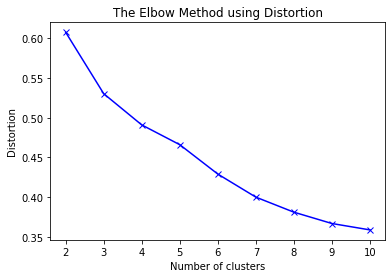

In [40]:
# scree plot
fig, ax = plt.subplots()

ax.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

### Using the different values of Inertia (WCSS):

In [86]:
for key, val in wcss_mapping.items():
    print(f'{key} : {val}')

2 : 151.65902250723494
3 : 116.52083192252748
4 : 99.19104266045733
5 : 86.93497865585985
6 : 75.27691438928183
7 : 65.80929602520955
8 : 59.77664401063546
9 : 55.29613588960134
10 : 51.653554738909605


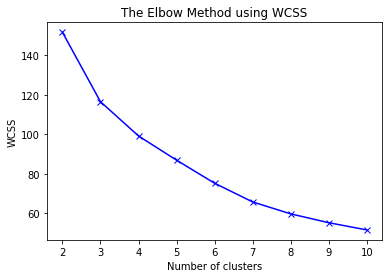

In [87]:
# scree plot
fig, ax = plt.subplots()

ax.plot(K, wcss, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('The Elbow Method using WCSS')
plt.show()

### Identify the elbow point programmatically

In [43]:
kl = KneeLocator(
    range(min_clusters, max_clusters), wcss, curve="convex", direction="decreasing"
)
kl.elbow

4

Even though programmatically, elbow value is 4 but through human eye, we feel comfortable with elbow value of 3

In [44]:

optimal_clusters = 3
optimal_clusters

3

### Interpretation of Scree Plot
 
From above visual interpretation, to determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion. In other words, there’s a sweet spot where the SSE (sum of the squared error) curve starts to bend known as the elbow point. The x-value of this point is thought to be a reasonable trade-off between error and number of clusters. In above example, the elbow is located at x=3. Thus for the given data, we conclude that the optimal number of clusters for the data is 3

## 6. Run K-means on Test Data and Compare Results to K-means on Train Data

In [88]:
# find the initial centroids (centers of the clusters) from the train centroids based on the optimal clusters
train_centroids = []

for j in range(len(centroids)):
    if(len(centroids[j]) == optimal_clusters):
        train_centroids = centroids[j]

if(len(train_centroids) == 0):
    raise Exception(f"Unable to find the centers of the clusters from the train data solution as a starting point from optimal clustes '{optimal_clusters}'")

train_centroids

array([[1.40407155e-01, 1.52655666e-16, 6.61991585e-01, 3.26086957e-02,
        5.72195384e-01, 4.47919089e-01, 8.83199749e-01, 8.89393985e-02,
        9.62192817e-01, 9.17855958e-01, 8.08048104e-01, 7.29840995e-01,
        4.78054271e-01],
       [9.28986921e-04, 3.26693548e-01, 1.68787248e-01, 1.61290323e-02,
        1.18493628e-01, 5.40624461e-01, 3.31567058e-01, 4.51698940e-01,
        1.42356241e-01, 2.08861734e-01, 5.36461908e-01, 9.80664796e-01,
        1.59695722e-01],
       [7.23228720e-03, 2.10507246e-02, 3.86105976e-01, 1.01449275e-01,
        3.88531043e-01, 4.96071277e-01, 8.13668861e-01, 1.70376290e-01,
        1.57529931e-01, 2.66650072e-01, 5.86262720e-01, 9.47441807e-01,
        3.21924144e-01]])

In [91]:
# run K-Means on the test data using the train data for fitting
# init = if an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.
test_cluster = KMeans(n_clusters=optimal_clusters, n_init=kmean_n_init, init=train_centroids, random_state=kmean_random_state) 
test_cluster.fit(X_test)
test_centroids = test_cluster.cluster_centers_

In [92]:
test_clust_size = {}
for j in range(0, optimal_clusters):
    # percentage of data points allocated in each cluster
    test_clust_size[j] = len(test_cluster.predict(X_test)[test_cluster.predict(X_test) == j]) / len(X_test)

### Compare Train Results to Test Results

In [93]:
# cluster sizes
print(f'Train Cluster Size : {clus_size[optimal_clusters-2]}')
print(f'Test Cluster Size : {test_clust_size}')

Train Cluster Size : {0: 0.2598870056497175, 1: 0.3502824858757062, 2: 0.3898305084745763}
Test Cluster Size : {0: 0.29605263157894735, 1: 0.34210526315789475, 2: 0.3618421052631579}


In [49]:
# centroids - with reverse scaling (train)
train_centroids_unscale = pd.DataFrame(scaler.inverse_transform(train_centroids))
train_centroids_unscale.columns = X.columns
train_centroids_unscale

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,12.498328,1.526557e-14,18.519130,0.032609,0.663087,6.040783,88.658696,2.143645,23.130435,667.956522,20.195652,290.376304,18.581413
1,0.088972,3.266935e+01,5.064516,0.016129,0.442588,6.491516,35.095161,6.118546,4.274194,296.443548,17.642742,389.276129,7.359274
2,0.649776,2.105072e+00,10.992971,0.101449,0.573826,6.274899,81.907246,3.035981,4.623188,326.724638,18.110870,376.176304,13.077826


In [50]:
# centroids - with reverse scaling (test)
test_centroids_unscale = pd.DataFrame(scaler.inverse_transform(test_centroids))
test_centroids_unscale.columns = X.columns
test_centroids_unscale

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,11.891978,-5.551115e-15,18.314222,0.111111,0.684444,5.935533,92.644444,1.872158,23.555556,667.000000,20.197778,292.394000,18.864889
1,0.134139,2.559615e+01,5.348077,0.076923,0.449573,6.658173,38.563462,5.602502,4.153846,286.269231,17.594231,389.175577,7.224423
2,0.650563,1.409091e+00,12.439636,0.127273,0.571364,6.183000,85.690909,3.087891,4.727273,333.963636,17.630909,367.000182,13.656000


In [51]:
# centroids - with reverse scaling (train - test)
abs(train_centroids_unscale - test_centroids_unscale)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.606350,2.081668e-14,0.204908,0.078502,0.021357,0.105249,3.985749,0.271487,0.425121,0.956522,0.002126,2.017696,0.283476
1,0.045167,7.073201e+00,0.283561,0.060794,0.006985,0.166657,3.468300,0.516044,0.120347,10.174318,0.048511,0.100552,0.134851
2,0.000788,6.959816e-01,1.446665,0.025823,0.002462,0.091899,3.783663,0.051910,0.104084,7.238999,0.479960,9.176123,0.578174


### Interpretation of K-means Train/Test Clustering Results
After comparing the results of the k-means clustering on the train and test data with 3 clusters we noticed the following:
- The % of data points in each cluster for both training and testing is very similar
- The unscaled centroids for the training and testing sets are very similar

## 7. Generate Gaussian Mixture Models

One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster. This works fine for when your data is circular. In contrast, Gaussian mixture models can handle even very oblong clusters. The second difference between k-means and Gaussian mixture models is that the former performs hard classification whereas the latter performs soft classification. In other words, k-means tells us what data point belong to which cluster but won’t provide us with the probabilities that a given data point belongs to each of the possible clusters.

In [52]:
min_gaussian_components = 3
max_gaussian_components = 6
gm_random_state = 50 #Determines random number generation for initialization
gm_n_init= 100       #The number of initializations to perform. The best results are kept.

In [53]:
aics = []
bics = []
n_components = range(min_gaussian_components, max_gaussian_components)
for i in n_components:
    gmm = GaussianMixture(random_state=gm_random_state, n_components=i, n_init=gm_n_init)
    gmm.fit(X_train)
    aics.append(gmm.aic(X_train))
    bics.append(gmm.bic(X_train))

## 8. Chosing Best GM Model and Interpret Results

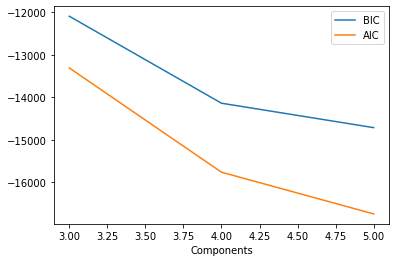

In [54]:
# scree plot
plt.plot(n_components, bics, label='BIC')
plt.plot(n_components, aics, label='AIC')
plt.legend(loc='best')
plt.xlabel('Components');
plt.show()

We train our GM model using the optimal number of components (in this case, 4)

In [55]:
# display means of gm clusters with 4 components
gmm = GaussianMixture(random_state=gm_random_state, n_components=4, n_init=gm_n_init)
gmm.fit(X_train)

gmm_means_unscale = pd.DataFrame(scaler.inverse_transform(gmm.means_))
gmm_means_unscale.columns = X.columns
gmm_means_unscale

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,11.749200,0.00000,18.309293,0.00,0.676717,6.018192,89.155556,2.121378,21.313131,628.808081,19.422222,287.232626,18.302323
1,0.869763,6.25000,11.758750,1.00,0.593250,6.238125,77.925000,3.114044,5.312500,317.562500,16.818750,364.081250,13.884375
2,0.206141,19.36758,6.384475,0.00,0.483411,6.442452,53.936073,4.911742,4.388128,298.826484,17.974886,388.330959,9.356712
3,1.415793,0.00000,22.491500,0.15,0.635950,6.006400,96.320000,1.968395,7.000000,526.150000,20.830000,379.569000,17.179000


In [56]:
# display centroids of Kmeans train cluster
train_centroids_unscale

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,12.498328,1.526557e-14,18.519130,0.032609,0.663087,6.040783,88.658696,2.143645,23.130435,667.956522,20.195652,290.376304,18.581413
1,0.088972,3.266935e+01,5.064516,0.016129,0.442588,6.491516,35.095161,6.118546,4.274194,296.443548,17.642742,389.276129,7.359274
2,0.649776,2.105072e+00,10.992971,0.101449,0.573826,6.274899,81.907246,3.035981,4.623188,326.724638,18.110870,376.176304,13.077826


### Compare Train GM Results to Trained K-means Results
For K-means, our scree plot indicated that 3 clusters was an optimal number of clusters, where as Gaussian Mixture shows from both the AIC and BIC plot that 4 clusters is more optimal. The above tables compare the centroids of the clusters for GM (top) and K-means (bottom)

## 9. Summarize Overall Results with Business Relevant Insights